Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** \
Чем больше параметр `batch_size`, тем дольше модель обучается по времени, но качество ее лучше (размер параметра обычно ограничивается только мощностью нашего железа, берем такой `batch_size`, который умещается в оперативную память). \
Модель при большом `batch_size` за одну итерацию смотрит на больший объем данных.


Посмотрим на какую-нибудь картинку:

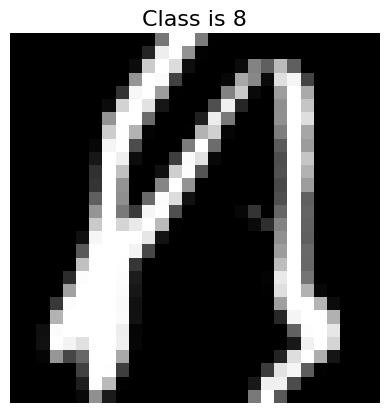

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





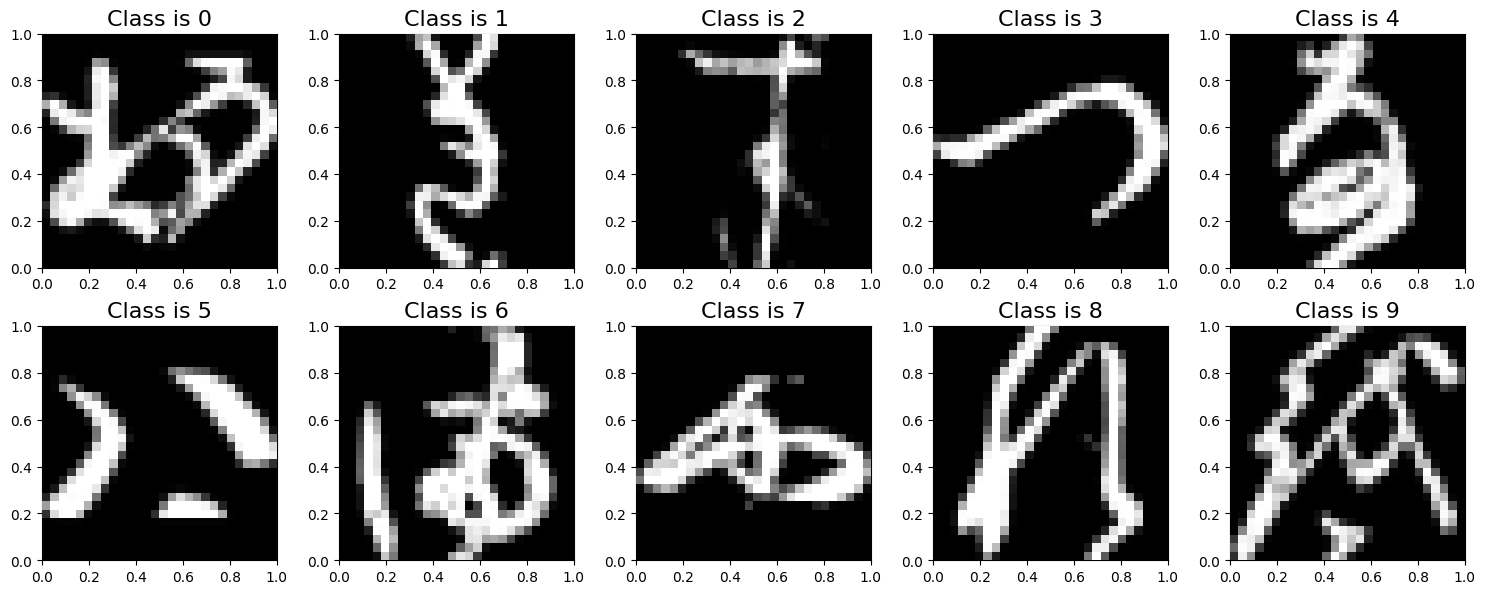

In [5]:
rows = 2
columns = 5

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
cl = 0

for num in range(1, rows*columns+1):
  for i in range(len(trainset)):
    if trainset[i][1] == num-1:
      fig.add_subplot(rows, columns, num) 
      plt.imshow(trainset[i][0].view(28, 28).numpy(), cmap="gray")   
      plt.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)
      plt.axis("off")
      plt.title(f"Class is {trainset[i][1]}", fontsize=16);
      cl += 1
      break
    
fig.tight_layout()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self, activation_func = F.relu):
        super().__init__() #  это надо помнить!
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation_func = activation_func
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        x = self.activation_func(x)
        x = self.fc3(x)
        logits = x

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [7]:
fc_net_test = FCNet()

In [8]:
fc_net_test

FCNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
for param in fc_net_test.parameters():
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


* У 1 слоя 256 нейронов, у каждого 784 весов; смещение = 256
* У 2 слоя 128 нейронов, у каждого 256 весов; смещение = 128
* У 3 слоя 10 нейронов, у каждого 128 весов; смещение = 10

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [10]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [11]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [12]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9222
Epoch=2 loss=0.4521
Epoch=3 loss=0.3582
Epoch=4 loss=0.3006
Epoch=5 loss=0.2573
Epoch=6 loss=0.2239
Epoch=7 loss=0.1959
Epoch=8 loss=0.1730
Epoch=9 loss=0.1522
Epoch=10 loss=0.1353
CPU times: user 30.7 s, sys: 2.18 s, total: 32.8 s
Wall time: 2min 9s


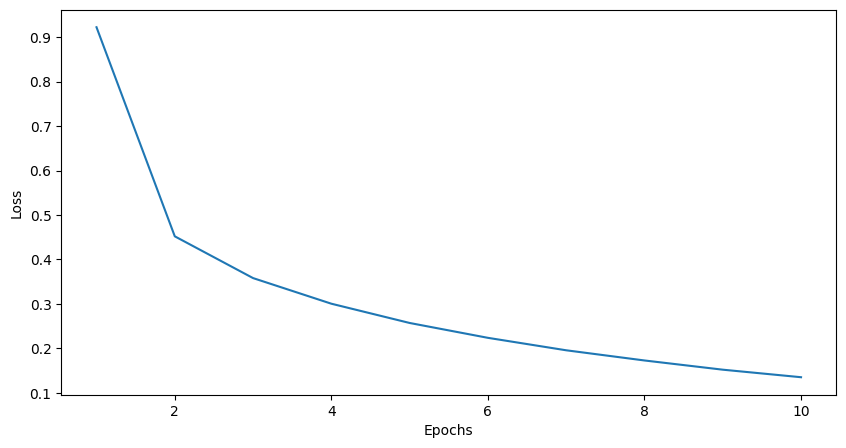

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [14]:
get_accuracy(fc_net, testloader)

0.8692

На тестовой выборке удалось получить  значение `accuracy` = **0.8692**

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [15]:
mean = np.array(trainset.data).flatten().mean() / 255 ## calculate mean
std = np.array(trainset.data).flatten().std() / 255 ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19176214735894356 0.3483428303463684


In [ ]:
for images, labels in trainloader:
  print(images)
  print(labels)
  break

In [17]:
img_tmp = np.array(images[0])

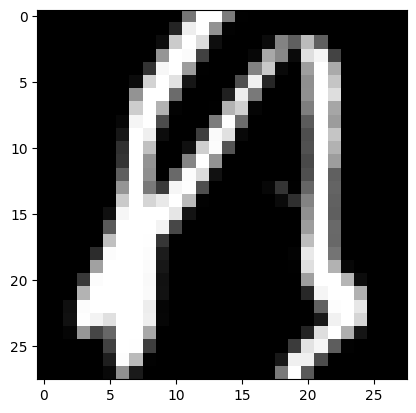

In [18]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")   

In [20]:
fc_net_norm = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_norm.parameters(), lr=3e-4)

In [21]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_norm(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6807
Epoch=2 loss=0.2963
Epoch=3 loss=0.2180
Epoch=4 loss=0.1689
Epoch=5 loss=0.1351
Epoch=6 loss=0.1097
Epoch=7 loss=0.0892
Epoch=8 loss=0.0723
Epoch=9 loss=0.0596
Epoch=10 loss=0.0486
CPU times: user 30.8 s, sys: 2.34 s, total: 33.1 s
Wall time: 2min 48s


In [27]:
get_accuracy(fc_net_norm, testloader)

0.9008

Как изменилась `accuracy` после нормализации?

Значение `accuracy` увеличилось после нормализации

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

### Sigmoid

In [23]:
class FCNet_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        logits_sigm = x

        return logits_sigm

In [24]:
fc_net_sigm = FCNet_Sigmoid()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_sigm.parameters(), lr=3e-4)

In [25]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_sigm(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.5552
Epoch=2 loss=0.7672
Epoch=3 loss=0.5535
Epoch=4 loss=0.4477
Epoch=5 loss=0.3751
Epoch=6 loss=0.3203
Epoch=7 loss=0.2773
Epoch=8 loss=0.2417
Epoch=9 loss=0.2124
Epoch=10 loss=0.1872
CPU times: user 30.9 s, sys: 2.2 s, total: 33.1 s
Wall time: 2min 45s


In [26]:
get_accuracy(fc_net_sigm, testloader)

0.8604

### GELU

In [28]:
class FCNet_GELU(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        logits_gelu = x

        return logits_gelu

In [29]:
fc_net_gelu = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_gelu.parameters(), lr=3e-4)

In [30]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_gelu(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6577
Epoch=2 loss=0.2828
Epoch=3 loss=0.2046
Epoch=4 loss=0.1559
Epoch=5 loss=0.1211
Epoch=6 loss=0.0971
Epoch=7 loss=0.0772
Epoch=8 loss=0.0618
Epoch=9 loss=0.0500
Epoch=10 loss=0.0382
CPU times: user 32.8 s, sys: 2.24 s, total: 35.1 s
Wall time: 3min 18s


In [31]:
get_accuracy(fc_net_gelu, testloader)

0.9023

### Tanh

In [32]:
class FCNet_Tanh(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        logits_tanh = x

        return logits_tanh

In [33]:
fc_net_tanh = FCNet_Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_tanh.parameters(), lr=3e-4)

In [34]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_tanh(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7755
Epoch=2 loss=0.3814
Epoch=3 loss=0.2582
Epoch=4 loss=0.1869
Epoch=5 loss=0.1397
Epoch=6 loss=0.1057
Epoch=7 loss=0.0797
Epoch=8 loss=0.0603
Epoch=9 loss=0.0440
Epoch=10 loss=0.0315
CPU times: user 31.5 s, sys: 2.31 s, total: 33.8 s
Wall time: 2min 43s


In [35]:
get_accuracy(fc_net_tanh, testloader)

0.8981

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**GELU**

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

### Adam

In [36]:
fc_net_gelu_adam = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_gelu_adam.parameters(), lr=3e-4)

In [37]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_gelu_adam(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6639
Epoch=2 loss=0.2767
Epoch=3 loss=0.2000
Epoch=4 loss=0.1528
Epoch=5 loss=0.1205
Epoch=6 loss=0.0968
Epoch=7 loss=0.0768
Epoch=8 loss=0.0615
Epoch=9 loss=0.0493
Epoch=10 loss=0.0390
CPU times: user 32.4 s, sys: 2.17 s, total: 34.6 s
Wall time: 2min 42s


In [38]:
get_accuracy(fc_net_gelu_adam, testloader)

0.9008

### RMSprop

In [39]:
fc_net_gelu_rms = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net_gelu_rms.parameters(), lr=3e-4)

In [40]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_gelu_rms(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4459
Epoch=2 loss=0.2420
Epoch=3 loss=0.1777
Epoch=4 loss=0.1362
Epoch=5 loss=0.1067
Epoch=6 loss=0.0841
Epoch=7 loss=0.0662
Epoch=8 loss=0.0519
Epoch=9 loss=0.0397
Epoch=10 loss=0.0317
CPU times: user 30.6 s, sys: 2.24 s, total: 32.8 s
Wall time: 2min 38s


In [41]:
get_accuracy(fc_net_gelu_rms, testloader)

0.9089

### Adagrad

In [42]:
fc_net_gelu_ada = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net_gelu_ada.parameters(), lr=3e-4)

In [43]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_gelu_ada(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3586
Epoch=2 loss=0.8224
Epoch=3 loss=0.6938
Epoch=4 loss=0.6310
Epoch=5 loss=0.5910
Epoch=6 loss=0.5621
Epoch=7 loss=0.5400
Epoch=8 loss=0.5219
Epoch=9 loss=0.5071
Epoch=10 loss=0.4937
CPU times: user 30 s, sys: 2.21 s, total: 32.2 s
Wall time: 2min 47s


In [44]:
get_accuracy(fc_net_gelu_ada, testloader)

0.7179

Лучшие результаты accuracy получились при использовании оптимизатора **RMSprop**

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [45]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x

        zeros_tensor = torch.zeros(x.shape)

        x[x < zeros_tensor] = 0

        return x

In [49]:
fc_net_custom = FCNet(activation_func = CustomReLU().forward)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net_custom.parameters(), lr=3e-4)

In [50]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net_custom(images) # получаем логиты
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3967
Epoch=2 loss=0.8773
Epoch=3 loss=0.7417
Epoch=4 loss=0.6740
Epoch=5 loss=0.6310
Epoch=6 loss=0.6004
Epoch=7 loss=0.5771
Epoch=8 loss=0.5573
Epoch=9 loss=0.5413
Epoch=10 loss=0.5271
CPU times: user 31.2 s, sys: 2.28 s, total: 33.4 s
Wall time: 2min 46s


In [51]:
get_accuracy(fc_net_custom, testloader)

0.71

In [69]:
sample_tensor = trainloader.dataset[0][0]

In [70]:
assert F.relu(sample_tensor).all() == CustomReLU().forward(sample_tensor).all()

Ошибок не выдает, функция `CustomReLU()` работает правильно

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Выпускной института биоинформатики: \
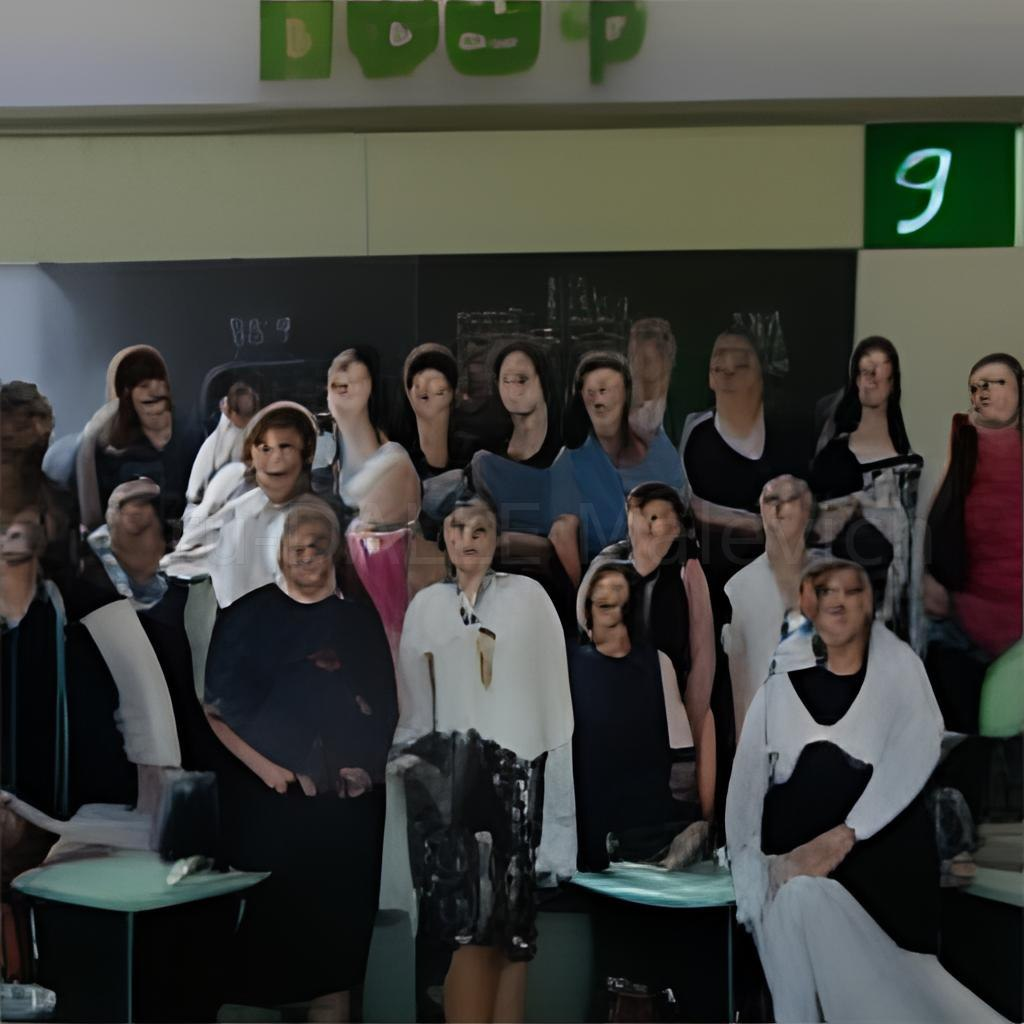

Музыкальный фестиваль в Москве: \
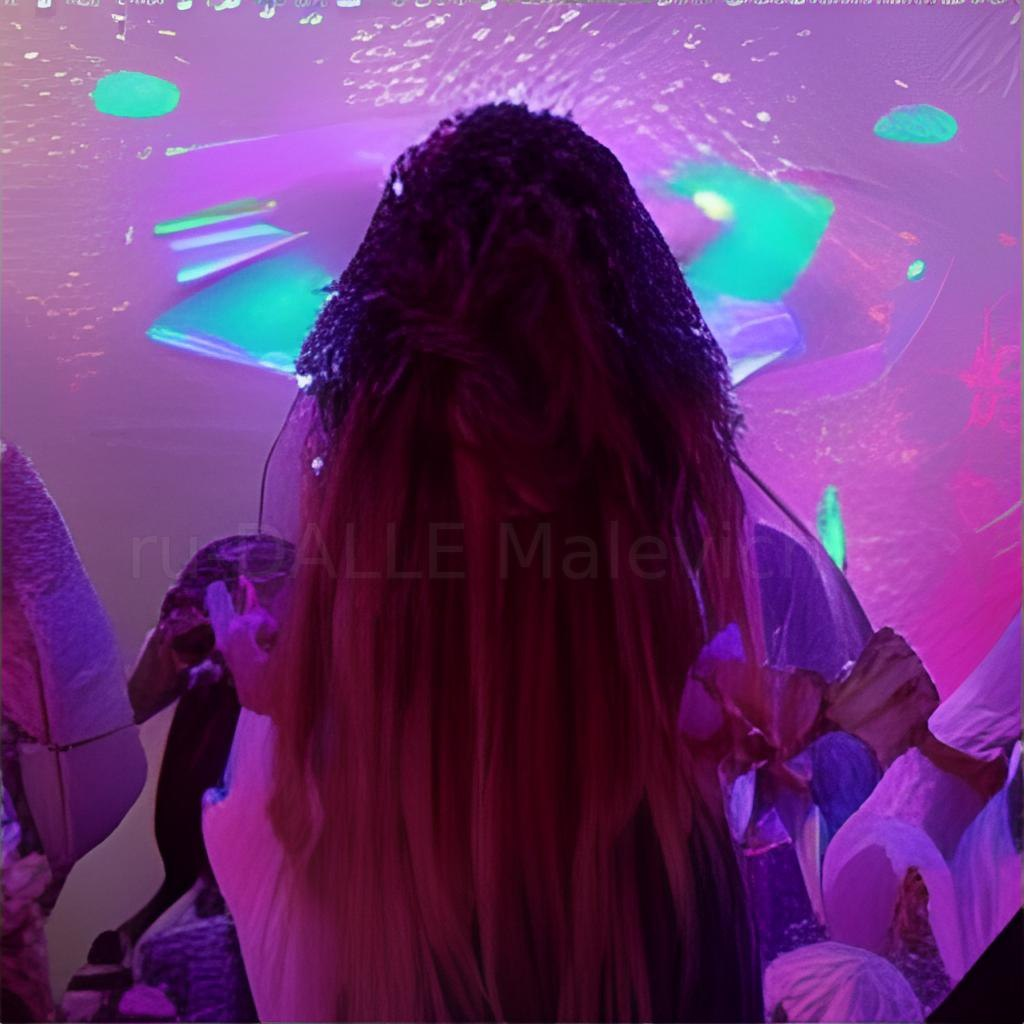

Офис IT-компании: \
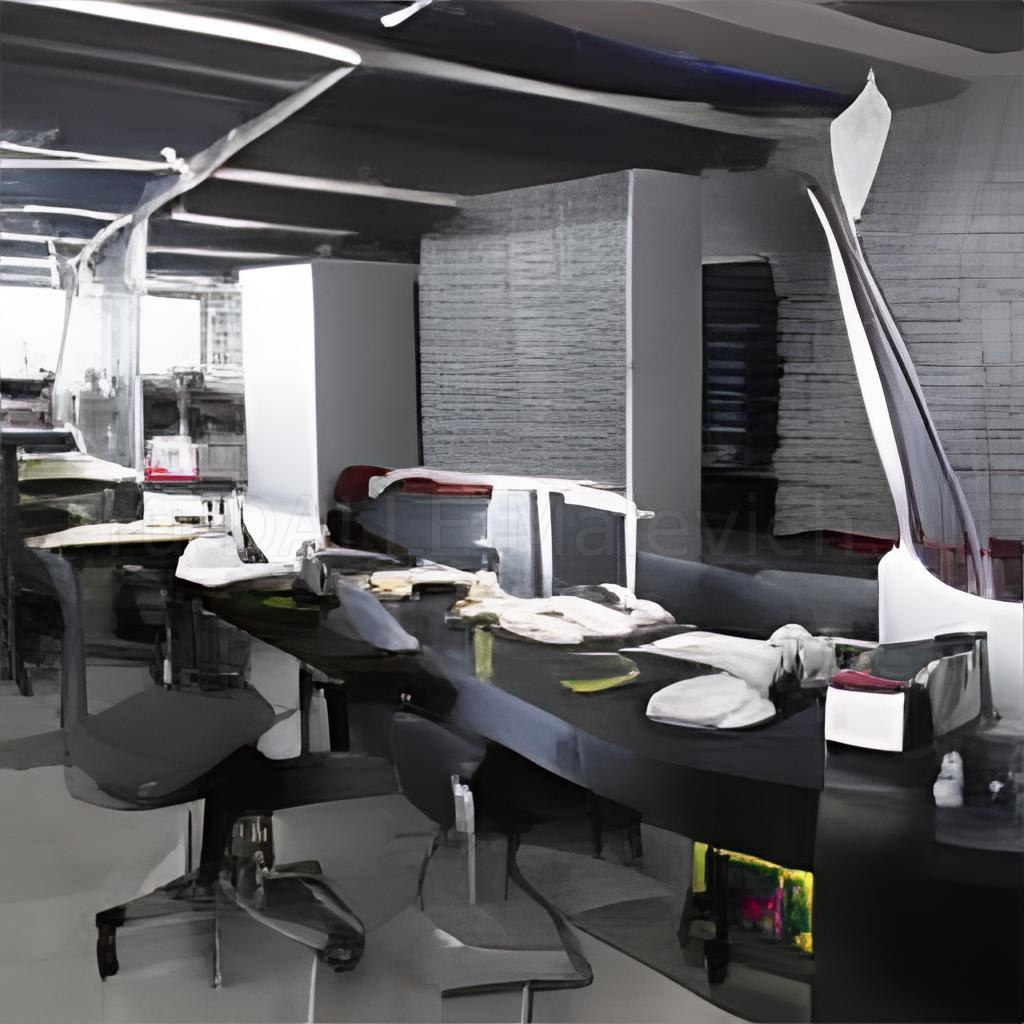